In [1]:
!pip freeze | egrep "torch|transformers"

open-clip-torch==2.23.0
pytorch-lightning==1.9.4
sentence-transformers==2.3.1
torch==2.1.0
torch-grammar==0.3.3
torchaudio==2.1.0
torchdiffeq==0.2.3
torchmetrics==1.2.0
torchsde==0.2.6
torchtyping==0.1.4
torchvision==0.16.0
transformers==4.37.2


# Embedding model wrapper

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch, torch.nn as nn

class EmbeddingModelWrapper():
    def __init__(self, model_path, bs=8):
        self.model, self.tokenizer = self.load_model(model_path)
        self.bs = bs

    def load_model(self, model_path):
        model = AutoModel.from_pretrained(
            model_path,
        ).cuda()
        model.eval()
        tokenizer = AutoTokenizer.from_pretrained(
             model_path,
        )
        return model, tokenizer

    def emb_mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embeddings(self, sentences):
        embeddings=torch.tensor([],device="cuda")
        
        if self.bs is None:
            batches=[sentences]
        else:
            batches = [sentences[i:i + self.bs] for i in range(0, len(sentences), self.bs)]  
            
        for sentences in batches:
            encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to("cuda")
            with torch.no_grad():
                model_output = self.model(**encoded_input)        
            batch_embeddings=self.emb_mean_pooling(model_output, encoded_input['attention_mask'])
            
            embeddings=torch.cat( (embeddings, batch_embeddings), dim=0 )

        return embeddings

    def get_similarities(self, x, y):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarities=[]
        for i in range(x.shape[0]):
            similarities.append(
                cos(
                    x[i,:].unsqueeze(0), 
                    y[i,:].unsqueeze(0),
                   ).item()
            )    
        return similarities

# 1. Hello World - apples and oranges

In [3]:
em = EmbeddingModelWrapper(
    model_path="models/all-mpnet-base-v2",
)

/home/g/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
em.get_embeddings("apple")

tensor([[-2.6158e-02,  1.0972e-03,  1.9490e-03, -1.5415e-01,  1.0197e-01,
         -3.9290e-02,  8.1013e-02, -7.5646e-02,  4.3267e-02,  1.0678e-03,
          5.1846e-02,  1.0715e-01,  6.8081e-02,  3.1373e-02, -8.5769e-02,
          1.4240e-01,  1.1476e-01,  1.7387e-01, -4.1105e-02, -3.7481e-02,
         -8.8261e-02,  7.2159e-02,  1.3279e-01, -7.4174e-02, -1.6154e-01,
         -8.7108e-02, -3.3193e-02,  2.8442e-02,  2.9079e-02,  2.1674e-02,
          5.3057e-02, -8.4183e-02, -1.7641e-01, -1.9407e-02,  5.7348e-06,
          2.6869e-02,  9.7349e-02, -3.7944e-02, -3.6554e-02,  1.5833e-01,
          4.0622e-02,  1.8161e-01, -1.0819e-01,  1.1764e-01, -9.2412e-02,
         -4.8116e-02,  3.8363e-02,  4.8428e-02,  8.8508e-02,  5.5698e-02,
         -8.4368e-02, -1.1390e-01, -1.2090e-01,  3.1135e-02, -1.0336e-01,
          2.5246e-02,  6.6967e-02, -1.7385e-02,  1.6231e-01,  9.1704e-04,
          1.0580e-01, -1.8477e-01,  8.3929e-02, -2.7656e-02, -1.4912e-01,
          6.6333e-02,  1.7666e-01, -7.

In [31]:
similarities = em.get_similarities(
    em.get_embeddings(["apple"]),
    em.get_embeddings(["orange"]),
)
similarities

[0.40115004777908325]

In [32]:
similarities = em.get_similarities(
    em.get_embeddings(["apple"]),
    em.get_embeddings(["car"]),
)
similarities

[0.31371933221817017]

In [35]:
similarities = em.get_similarities(
    em.get_embeddings(["love"]),
    em.get_embeddings(["hate"]),
)
similarities

[0.47539061307907104]

# 2. Apply to LMSYS Arena data

In [39]:
from datasets import load_dataset

dataset = load_dataset("lmsys/chatbot_arena_conversations")["train"]

In [40]:
dataset

Dataset({
    features: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn', 'anony', 'language', 'tstamp', 'openai_moderation', 'toxic_chat_tag'],
    num_rows: 33000
})

In [41]:
dataset[0]

{'question_id': '58210e39b3fd4441a2bd4a518bb44c2d',
 'model_a': 'chatglm-6b',
 'model_b': 'koala-13b',
 'winner': 'model_b',
 'judge': 'arena_user_973',
 'conversation_a': [{'content': 'What is the difference between OpenCL and CUDA?',
   'role': 'user'},
  {'content': 'OpenCL and CUDA are two different programming models that are used for parallel computing.OpenCL is a general-purpose并行编程接口 that allows developers to write parallel code that can run on any platform that supportsCL, which includes most modern operating systems and computer systems, including Windows, Linux, and macOS. It provides a lower-level, more flexible API that is more suitable for building large-scale distributed computing systems.CUDA is a specific implementation ofOpenCL that is designed for performance and scalability in devices with multiple GPU(s). It was developed by Nvidia and is widely used for scientific computing, machine learning, and图形图像处理. The CUDA API provides a high-level, more efficient way to wri

In [65]:
from tqdm import tqdm 

reference_model="gpt-4"
answers={}

for judgement in tqdm(dataset):
    if not reference_model in judgement["model_a"]+judgement["model_b"]: continue   
    model_ref="a" if judgement["model_a"] == reference_model else "b"
    model_other="b" if model_ref == "a" else "a"

    answers_ref = [ msg["content"] for msg in judgement[f"conversation_{model_ref}"] if msg["role"]=="assistant" ] 
    answers_other = [ msg["content"] for msg in judgement[f"conversation_{model_other}"] if msg["role"]=="assistant" ] 

    model=judgement[f"model_{model_other}"]
    if not model in answers:
        display(model)
        answers[model]=dict(answers_model=[], answers_ref=[])

    answers[model]["answers_model"].extend(answers_other)
    answers[model]["answers_ref"].extend(answers_ref)
    

 14%|█████▎                               | 4737/33000 [00:06<00:36, 783.11it/s]

'vicuna-13b'

'oasst-pythia-12b'

'koala-13b'

'gpt-3.5-turbo'

 15%|█████▍                               | 4817/33000 [00:06<00:42, 660.40it/s]

'llama-13b'

'fastchat-t5-3b'

'chatglm-6b'

'dolly-v2-12b'

'stablelm-tuned-alpha-7b'

'alpaca-13b'

 18%|██████▌                              | 5836/33000 [00:08<00:48, 563.24it/s]

'claude-v1'

'RWKV-4-Raven-14B'

 33%|███████████▉                        | 10947/33000 [00:15<00:33, 664.84it/s]

'mpt-7b-chat'

 44%|███████████████▋                    | 14395/33000 [00:19<00:24, 745.67it/s]

'palm-2'

 59%|█████████████████████               | 19329/33000 [00:26<00:20, 680.77it/s]

'vicuna-7b'

 59%|█████████████████████▎              | 19503/33000 [00:26<00:18, 731.90it/s]

'claude-instant-v1'

 88%|███████████████████████████████▌    | 28887/33000 [00:40<00:05, 711.07it/s]

'gpt4all-13b-snoozy'

 88%|███████████████████████████████▌    | 28962/33000 [00:40<00:05, 718.38it/s]

'wizardlm-13b'

 88%|███████████████████████████████▋    | 29059/33000 [00:40<00:05, 787.45it/s]

'guanaco-33b'

100%|████████████████████████████████████| 33000/33000 [00:45<00:00, 720.72it/s]


In [67]:
models=list(answers.keys())

for model in models:
    print(model, len(answers[model]["answers_model"]), "answers")

vicuna-13b 448 answers
oasst-pythia-12b 395 answers
koala-13b 417 answers
gpt-3.5-turbo 436 answers
llama-13b 117 answers
fastchat-t5-3b 258 answers
chatglm-6b 266 answers
dolly-v2-12b 193 answers
stablelm-tuned-alpha-7b 225 answers
alpaca-13b 290 answers
claude-v1 366 answers
RWKV-4-Raven-14B 346 answers
mpt-7b-chat 258 answers
palm-2 247 answers
vicuna-7b 249 answers
claude-instant-v1 191 answers
gpt4all-13b-snoozy 80 answers
wizardlm-13b 73 answers
guanaco-33b 90 answers


In [70]:
from statistics import mean

models_similarities=[]

for model in tqdm(models):
    similarities = em.get_similarities(
        em.get_embeddings(answers[model]["answers_model"]),
        em.get_embeddings(answers[model]["answers_ref"]),
    )
    models_similarities.append( mean(similarities) )
    print( model, similarities[-1] )

  5%|██▎                                         | 1/19 [00:15<04:41, 15.66s/it]

vicuna-13b 0.8578882217407227


 11%|████▋                                       | 2/19 [00:30<04:18, 15.20s/it]

oasst-pythia-12b 0.47900500893592834


 16%|██████▉                                     | 3/19 [00:45<04:04, 15.28s/it]

koala-13b 0.8484880924224854


 21%|█████████▎                                  | 4/19 [01:01<03:49, 15.28s/it]

gpt-3.5-turbo 0.8834269046783447


 26%|███████████▌                                | 5/19 [01:05<02:36, 11.16s/it]

llama-13b 0.45220327377319336


 32%|█████████████▉                              | 6/19 [01:14<02:15, 10.44s/it]

fastchat-t5-3b 0.6493669748306274


 37%|████████████████▏                           | 7/19 [01:23<02:01, 10.16s/it]

chatglm-6b 0.5579537153244019


 42%|██████████████████▌                         | 8/19 [01:30<01:39,  9.00s/it]

dolly-v2-12b 0.745858907699585


 47%|████████████████████▊                       | 9/19 [01:38<01:27,  8.75s/it]

stablelm-tuned-alpha-7b 0.7293763160705566


 53%|██████████████████████▋                    | 10/19 [01:47<01:19,  8.84s/it]

alpaca-13b 0.7523584365844727


 58%|████████████████████████▉                  | 11/19 [02:01<01:22, 10.33s/it]

claude-v1 0.8397925496101379


 63%|███████████████████████████▏               | 12/19 [02:13<01:16, 10.89s/it]

RWKV-4-Raven-14B 0.7650090456008911


 68%|█████████████████████████████▍             | 13/19 [02:22<01:01, 10.24s/it]

mpt-7b-chat 0.5898827910423279


 74%|███████████████████████████████▋           | 14/19 [02:31<00:49,  9.95s/it]

palm-2 0.3190893530845642


 79%|█████████████████████████████████▉         | 15/19 [02:40<00:38,  9.63s/it]

vicuna-7b 0.7728925943374634


 84%|████████████████████████████████████▏      | 16/19 [02:47<00:26,  8.86s/it]

claude-instant-v1 0.6077674627304077


 89%|██████████████████████████████████████▍    | 17/19 [02:49<00:13,  6.97s/it]

gpt4all-13b-snoozy 0.26017242670059204


 95%|████████████████████████████████████████▋  | 18/19 [02:52<00:05,  5.79s/it]

wizardlm-13b 0.9506160020828247


100%|███████████████████████████████████████████| 19/19 [02:56<00:00,  9.28s/it]

guanaco-33b 0.7739665508270264


In [75]:
sorted_indices = sorted(range(len(models_similarities)), key=lambda index: models_similarities[index], reverse=True)

for i in sorted_indices:
    print(models[i], models_similarities[i])

wizardlm-13b 0.8138260962824299
claude-v1 0.8011753687054896
gpt-3.5-turbo 0.7997970185584363
claude-instant-v1 0.7739336014340061
vicuna-13b 0.7696723944391124
guanaco-33b 0.7652262987362014
vicuna-7b 0.740021856254842
koala-13b 0.7112154742921714
fastchat-t5-3b 0.7092030091398909
gpt4all-13b-snoozy 0.7083628309424966
mpt-7b-chat 0.7058982313033049
alpaca-13b 0.6989613604442827
chatglm-6b 0.6951124396322197
RWKV-4-Raven-14B 0.6907683522198241
oasst-pythia-12b 0.6675865416709758
palm-2 0.6627612474717592
stablelm-tuned-alpha-7b 0.6604965678188536
dolly-v2-12b 0.6023693506272964
llama-13b 0.5296028090967263


In [77]:
elo_ratings_raw = \
"""1	gpt-4-turbo	1250
2	bard-jan-24-gemini-pro	1214
3	gpt-4-0314	1189
4	gpt-4-0613	1161
5	mistral-medium	1150
6	claude-1	1150
7	claude-2.0	1131
8	mixtral-8x7b-instruct-v0.1	1122
9	gemini-pro-dev-api	1122
10	claude-2.1	1119
11	gpt-3.5-turbo-0613	1117
12	gemini-pro	1114
13	yi-34b-chat	1112
14	claude-instant-1	1110
15	wizardlm-70b	1106
16	tulu-2-dpo-70b	1105
17	gpt-3.5-turbo-0314	1104
18	deepseek-llm-67b-chat	1099
19	vicuna-33b	1094
20	starling-lm-7b-alpha	1089
21	llama-2-70b-chat	1081
22	llama2-70b-steerlm-chat	1078
23	openchat-3.5	1077
24	openhermes-2.5-mistral-7b	1076
25	pplx-70b-online	1074
26	gpt-3.5-turbo-1106	1072
27	solar-10.7b-instruct-v1.0	1065
28	dolphin-2.2.1-mistral-7b	1064
29	wizardlm-13b	1058
30	zephyr-7b-beta	1050
31	mpt-30b-chat	1043
32	codellama-34b-instruct	1042
33	vicuna-13b	1040
34	llama-2-13b-chat	1039
35	zephyr-7b-alpha	1037
36	pplx-7b-online	1036
37	qwen-14b-chat	1034
38	falcon-180b-chat	1032
39	guanaco-33b	1031
40	llama-2-7b-chat	1021
41	stripedhyena-nous-7b	1017
42	mistral-7b-instruct	1010
43	palm-2	1005
44	vicuna-7b	1005
45	koala-13b	965
46	chatglm3-6b	960
47	gpt4all-13b-snoozy	937
48	mpt-7b-chat	930
49	chatglm2-6b	929
50	RWKV-4-Raven-14B	924
51	alpaca-13b	904
52	oasst-pythia-12b	896
53	chatglm-6b	883
54	fastchat-t5-3b	874
55	stablelm-tuned-alpha-7b	844
56	dolly-v2-12b	822
57	llama-13b	800"""

In [80]:
elo_ratings={}

for line in elo_ratings_raw.split("\n"):
    line_split=line.split("\t")
    model=line_split[1]
    elo=line_split[2]
    elo_ratings[model]=elo

In [81]:
elo_ratings

{'gpt-4-turbo': '1250',
 'bard-jan-24-gemini-pro': '1214',
 'gpt-4-0314': '1189',
 'gpt-4-0613': '1161',
 'mistral-medium': '1150',
 'claude-1': '1150',
 'claude-2.0': '1131',
 'mixtral-8x7b-instruct-v0.1': '1122',
 'gemini-pro-dev-api': '1122',
 'claude-2.1': '1119',
 'gpt-3.5-turbo-0613': '1117',
 'gemini-pro': '1114',
 'yi-34b-chat': '1112',
 'claude-instant-1': '1110',
 'wizardlm-70b': '1106',
 'tulu-2-dpo-70b': '1105',
 'gpt-3.5-turbo-0314': '1104',
 'deepseek-llm-67b-chat': '1099',
 'vicuna-33b': '1094',
 'starling-lm-7b-alpha': '1089',
 'llama-2-70b-chat': '1081',
 'llama2-70b-steerlm-chat': '1078',
 'openchat-3.5': '1077',
 'openhermes-2.5-mistral-7b': '1076',
 'pplx-70b-online': '1074',
 'gpt-3.5-turbo-1106': '1072',
 'solar-10.7b-instruct-v1.0': '1065',
 'dolphin-2.2.1-mistral-7b': '1064',
 'wizardlm-13b': '1058',
 'zephyr-7b-beta': '1050',
 'mpt-30b-chat': '1043',
 'codellama-34b-instruct': '1042',
 'vicuna-13b': '1040',
 'llama-2-13b-chat': '1039',
 'zephyr-7b-alpha': '1037

In [92]:
sorted_indices = sorted(range(len(models_similarities)), key=lambda index: models_similarities[index], reverse=True)

model_map_elo = {
    "claude-v1": "claude-1",
    "gpt-3.5-turbo": "gpt-3.5-turbo-0613",
    "claude-instant-v1": "claude-instant-1"
}
model_elo=[]
for model in models:
    model_elo_name=model if not model in model_map_elo else model_map_elo[model]
    elo=elo_ratings[model_elo_name] if model_elo_name in elo_ratings else None
    model_elo.append(int(elo))

In [93]:
sorted_indices = sorted(range(len(models_similarities)), key=lambda index: models_similarities[index], reverse=True)

for i in sorted_indices:
    print(models[i], models_similarities[i], model_elo[i])

wizardlm-13b 0.8138260962824299 1058
claude-v1 0.8011753687054896 1150
gpt-3.5-turbo 0.7997970185584363 1117
claude-instant-v1 0.7739336014340061 1110
vicuna-13b 0.7696723944391124 1040
guanaco-33b 0.7652262987362014 1031
vicuna-7b 0.740021856254842 1005
koala-13b 0.7112154742921714 965
fastchat-t5-3b 0.7092030091398909 874
gpt4all-13b-snoozy 0.7083628309424966 937
mpt-7b-chat 0.7058982313033049 930
alpaca-13b 0.6989613604442827 904
chatglm-6b 0.6951124396322197 883
RWKV-4-Raven-14B 0.6907683522198241 924
oasst-pythia-12b 0.6675865416709758 896
palm-2 0.6627612474717592 1005
stablelm-tuned-alpha-7b 0.6604965678188536 844
dolly-v2-12b 0.6023693506272964 822
llama-13b 0.5296028090967263 800


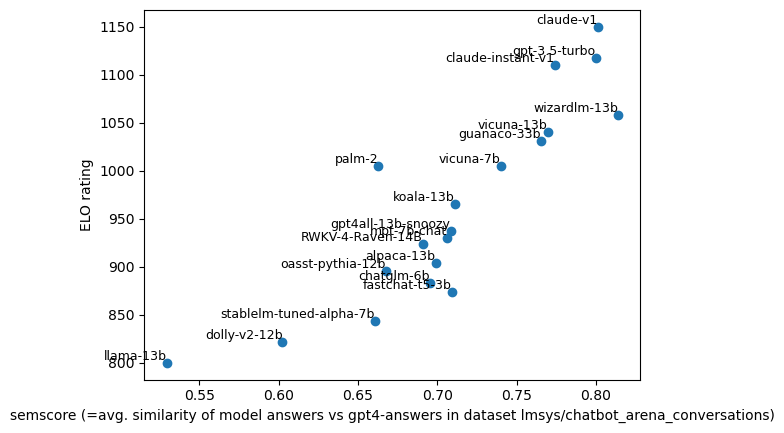

In [127]:
import matplotlib.pyplot as plt

plt.scatter(models_similarities, model_elo)

plt.xlabel('semscore (=avg. similarity of model answers vs gpt4-answers in dataset lmsys/chatbot_arena_conversations)')
plt.ylabel('ELO rating')

for i, model in enumerate(models):
    plt.text(models_similarities[i], model_elo[i], model, fontsize=9, ha='right', va='bottom')

plt.show()


In [119]:
import pandas as pd

rank_elo = sorted(range(len(model_elo)), key=lambda index: model_elo[index], reverse=True)
rank_sim = sorted(range(len(models_similarities)), key=lambda index: models_similarities[index], reverse=True)

data = {
    'Model': models,
    'sim': models_similarities,
    'elo': model_elo,
    'rank_sim': [ rank_sim.index(i)+1 for i in range(len(models)) ],
    'rank_elo': [ rank_elo.index(i)+1 for i in range(len(models)) ],
}

df = pd.DataFrame(data)
df_sorted = df.sort_values(by=['rank_elo'], ascending=[True])
df_sorted

,Model,sim,elo,rank_sim,rank_elo
10,claude-v1,0.801175,1150,2,1
3,gpt-3.5-turbo,0.799797,1117,3,2
15,claude-instant-v1,0.773934,1110,4,3
17,wizardlm-13b,0.813826,1058,1,4
0,vicuna-13b,0.769672,1040,5,5
18,guanaco-33b,0.765226,1031,6,6
13,palm-2,0.662761,1005,16,7
14,vicuna-7b,0.740022,1005,7,8
2,koala-13b,0.711215,965,8,9
16,gpt4all-13b-snoozy,0.708363,937,10,10
